
# TP CNN
### Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   
2021-2022

## Introduction

In [1]:
from IPython.display import Image
import tensorflow as tf
# print(tensorflow.__version__)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation
import matplotlib.pyplot as plt


**The GPU**



To enable GPU backend in Google colab for your notebook:

1.   Runtime (top left corner) -> Change runtime type
2.   Put GPU as "Hardware accelerator"
3.   Save.

Or run the next cell:

In [2]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Convolutional Neural Networks (CNN)

Derived from the MLP, a convolutional neural network (CNN) is a type of artificial neural network that is specifically designed to process **pixel data**.  The layers of a CNN consist of an **input layer**, an **output layer** and **hidden layers** that can include **convolutional layers**, **pooling layers**, **fully connected layers** and **normalization layers**. It exists a lot of techniques to optimize CNN, like for example the dropout.

### Loading the dataset
In this part, we will use photographies of animals from the kaggle dataset [animals-10](https://www.kaggle.com/alessiocorrado99/animals10). Please connect to their site before loading the dataset from this [zip file](http://www.i3s.unice.fr/~lingrand/raw-img.zip). Decompress the zip file on your disk.

If you are using google colab, there is no need to download the dataset because I have a copy on my drive. You just need add to your drive this shared folder: https://drive.google.com/drive/folders/15cB1Ky-7OTUqfcQDZZyzc5HArt0GA6Sm?usp=sharing
You need to click on the link and click on "Add shortcut to Drive" and then select "My Drive".

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

To feed the data to a CNN, we need to shape it as required by Keras. As input, a 2D convolutional layer needs a **4D tensor** with shape: **(batch, rows, cols, channels)**. Therefore, we need to precise the "channels" axis, which can be seen as the number of level of color of each input: 3 channels in our case. We will fix the dimension of images according to the VGG-16 network: (224, 224).


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix, f1_score #, plot_confusion_matrix #does not work anymore
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
# when processing time is long, it's nice to see the progress bar
#!pip install tqdm
from tqdm import tqdm

### loading train data

Please read the code before running any of the cells!

In [5]:
datasetRoot='raw-img/'
#datasetRoot='/whereYouPutTheImages/'
#datasetRoot='/content/drive/My Drive/raw-img/'
# I suggest to reduce the number of classes for a first trial. 
# If you finish this notebook before the end of the course, you can add more classes (and images per class).
classes = ['mucca', 'elefante', 'gatto'] #, 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0
reducedSizePerClass = 200 #in order to reduce the number of images per class
totalImg = nbClasses * reducedSizePerClass
xTrain = np.empty(shape=(totalImg,224,224,3))
yTrain = []
first = True
i= 0
for cl in classes:
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*reducedSizePerClass #len(listImages) # note that here ...
    for pathImg in tqdm(listImages[:reducedSizePerClass]): # and here, we have reduced the data to be loaded (only 1000 per class)
        img = image.load_img(pathImg, target_size=(224,224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTrain[i,:,:,:] = im
        i += 1
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)
yTrain = tensorflow.keras.utils.to_categorical(yTrain, nbClasses)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 309.88it/s]

600
(600, 224, 224, 3)


In order to speed-up the time spent on this part of the lab, you may have noticed that we reduced the number of classes and the number of images per class. You can change these few lines of code if you want to work on the whole dataset.

### loading test data

In [15]:
#you need to use the same classes for the test dataset than for the train dataset
rootTest = datasetRoot+'test/'
classLabel = 0

totalTestImg = 0
for cl in classes:
    totalTestImg += len(glob.glob(rootTest+cl+'/*'))

print("There are ",totalTestImg, " images in test dataset.")
xTest = np.empty(shape=(totalTestImg,224,224,3))
yTest = []
i = 0

for cl in classes:
    listImages = glob.glob(rootTest+cl+'/*')
    yTest += [classLabel]*len(listImages)
    for pathImg in listImages:
        img = image.load_img(pathImg, target_size=(224, 224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTest[i,:,:,:] = im 
        i += 1
    classLabel += 1
print(len(yTest))
print(xTest.shape)
yTest = tensorflow.keras.utils.to_categorical(yTest, nbClasses)

There are  998  images in test dataset.
998
(998, 224, 224, 3)


## Build your own CNN network

In [16]:
xTrain.shape

(600, 224, 224, 3)

Start with the simplest CNN: 1 conv2D layer + 1 pooling + 1 dense layer.

In [17]:
model = Sequential()
#32 filter/channels of dimension 3*3, shape of image is 224*224*3,stride 4  #------------------- VERY IMPORTANT TO UNDERSTAND THAT
#input : if stride = 4  input=224/4,224/4,filter = 56,56,32 --> after flatten we have length of vector 56*56*32=100352
model.add(Conv2D(32,(3,3),padding='same',activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(4, 4), strides=4, padding='same')) #reduce parameters jcrois
model.add(Flatten()) #here we can also do globalaveragepooling
model.add(Dense(nbClasses, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

Let's look at the dimension of all inputs and outputs:

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 3)                 301059    
                                                                 
Total params: 301,955
Trainable params: 301,955
Non-trainable params: 0
_________________________________________________________________


Learn and test this network. 

In [19]:
# for you !

# fit model using ealy stopping 
es = EarlyStopping(
  monitor="val_accuracy",
  mode="auto",
  min_delta=0.0001,
  patience=10,
  restore_best_weights=True,
  verbose=2,
)
history = model.fit(
  x=xTrain,
  y=yTrain,
  epochs=1000,
  validation_split=0.2,
  callbacks=[es],
  verbose=2,

)




Epoch 1/1000
15/15 - 10s - loss: 1476.7242 - accuracy: 0.4187 - val_loss: 233.5133 - val_accuracy: 0.4167 - 10s/epoch - 694ms/step
Epoch 2/1000
15/15 - 7s - loss: 349.7051 - accuracy: 0.5750 - val_loss: 408.5953 - val_accuracy: 0.2500 - 7s/epoch - 471ms/step
Epoch 3/1000
15/15 - 7s - loss: 249.0271 - accuracy: 0.6250 - val_loss: 105.7134 - val_accuracy: 0.6333 - 7s/epoch - 463ms/step
Epoch 4/1000


KeyboardInterrupt: 

In [ ]:
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

In [12]:
# for you !
model.evaluate(xTest,yTest)

32/32 [==============================] - 5s 141ms/step - loss: 199.4841 - accuracy: 0.5952


[199.48411560058594, 0.5951904058456421]

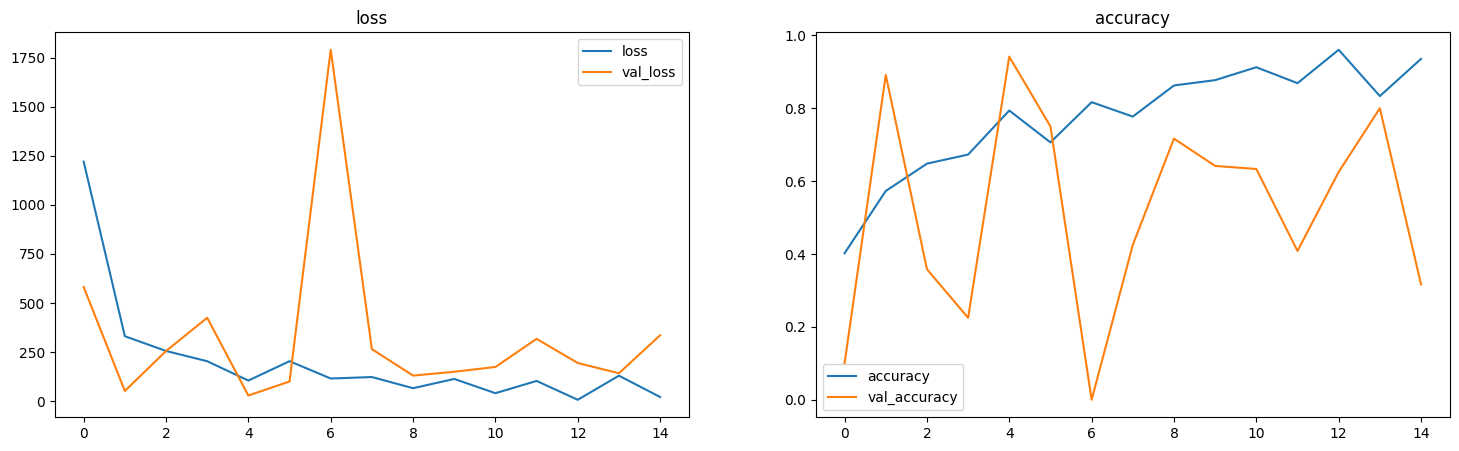

In [13]:
babysit(history.history)

How is the accuracy or F1-measure on the test dataset?

Are you satisfied by the performances?

Try to modify the architecture (add layers) and some of the parameters.

For the training set, the loss is decreasing, the accuracy is increasing 

But for the val set, its not very good we have the same thing at beginging and at the end --> overfitting

### About Dropout 

*Study this part only if you have time for it. It concerns the previous network but prefer to study first part II and come back here after.*

Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass.

Why use dropout ? A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to overfitting of training data.

**Let's add dropout and activation functions to the network!**

So its kernel*(size of kernel*size of kernel*channel+1) if its the first Conv2D

If its not the first Conv2D its : kernel*(size of kernel*size of kernel*PreviousKernel+1)

Exemple : 

model.add(Conv2D(kernel,(size_of_kernel1,size_of_kernel2),activation='relu',input_shape=(height,width,channel)))

--> number of parameters = kernel*(size of kernel1*size of kernel2*channel+1) for the 1st Conv2D

--> number of parameters = kernel*(size of kernel1*size of kernel2*previous_kernel) for the following ones

Regardinx MaxPooling : 

usually after a convolutional layer

reduces the size of data (downsampling)

In [14]:
from tensorflow.keras.layers import Dropout

model = Sequential(name='MLP model with dropout') 

model = Sequential()

#mostly, for 1st CONV2D layer channel is 3
#256 kernel, #3*3 size of kernels        #224,224 width*height  #3 is channel
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(224,224,3))) #-->7168=256*(3*3*3+1) le 3eme 3 c channel
#but here, the channel is the previous kernel (256 in this case)
model.add(Conv2D(60,(11,11),activation='relu',input_shape=(224,224,9))) #1858620=60*(11*11*256+1)


model.add(GlobalAveragePooling2D())
model.add(Dense(200,activation='relu'))
# adding dropout to the previous layer
model.add(Dropout(0.2))


model.add(Dense(nbClasses, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 256)     7168      
                                                                 
 conv2d_2 (Conv2D)           (None, 212, 212, 60)      1858620   
                                                                 
 global_average_pooling2d (G  (None, 60)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 200)               12200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                      

In [ ]:
# learn again your CNN with dropout

es = EarlyStopping(
  monitor="val_accuracy",
  mode="auto",
  min_delta=0.0001,
  patience=10,
  restore_best_weights=True,
  verbose=2,
)
history = model.fit(
  x=xTrain,
  y=yTrain,
  epochs=4000,
  validation_split=0.2,
  callbacks=[es],
  verbose=2,
)


Epoch 1/4000


In [ ]:
model.evaluate(xTest,yTest)

In [ ]:
babysit(history.history)

## Using a pre-learned network

### loading VGG-16 description part and adding layers to build our own classification network

In [ ]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
VGGmodel.summary()

In [ ]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m) #could be flatten, global max pool...
# and add a fully-connected layer
m = Dense(128, activation='relu')(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)


Can you display the architecture of this entire network?

In [ ]:
# for you
model.summary()

In [ ]:
# training
ourCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
 
# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[ourCallback],verbose=1)

### fine-tune the network

Fine-tune the entire network if you have enough computing ressouces, otherwise, carefully choose the layers you want to fine-tune.

In [ ]:
for i, layer in enumerate(VGGmodel.layers):
   print(i, layer.name)
model.summary()

In this example, we will fine-tune the last convolution block starting at layer number 15 (block5_conv).

In [ ]:
from tensorflow.keras.optimizers import RMSprop
for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True
#need to recompile the network
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
#and train again ...
model.fit(xTrain, yTrain, epochs=20, batch_size=128, validation_split=0.2, callbacks=[ourCallback],verbose=1)

You already know how to evaluate the performances on the test dataset and display the confusion matrix. You can also modify the code that loads the test dataset in order to reduce it's size. Let's do it!

In [ ]:
#enter here your code for evaluation of performances
model.evaluate(xTest,yTest)

In [ ]:
babysit(history.history)

You are now free to experiments changes in the network:
* add a dense layer
* modify the number of neurons in dense layer(s)
* change the global average polling
* add classes and data
* experiment other optimizers (SGD, Adam, ...)


...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


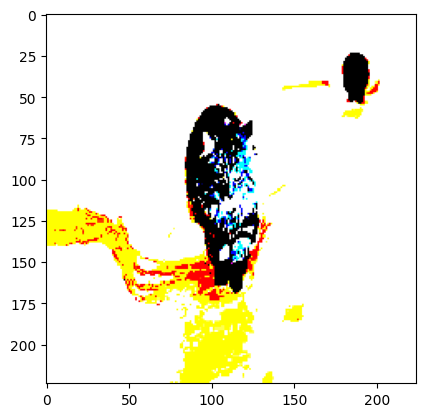

In [45]:
import cv2

plt.imshow(xTrain[599])
plt.show()

In [46]:
VGG = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=VGG.input,outputs=[VGG.get_layer('block5_conv3').output,VGG.output])
img=xTrain[599]

In [47]:

with tf.GradientTape() as tape:
    output, predictions = model(np.array([img]))
    cl = np.argmax(predictions)
    score = predictions[:, cl]
featureMaps = output[0]
gradients = tape.gradient(score, output)[0]


In [63]:
weights = tf.reduce_mean(gradients, axis=(0, 1))


WfeatureMaps=weights*featureMaps
cam = np.maximum(cam, 0) / np.max(cam)


In [70]:
cam = cv2.resize(cam, (img.shape[0], img.shape[1]))

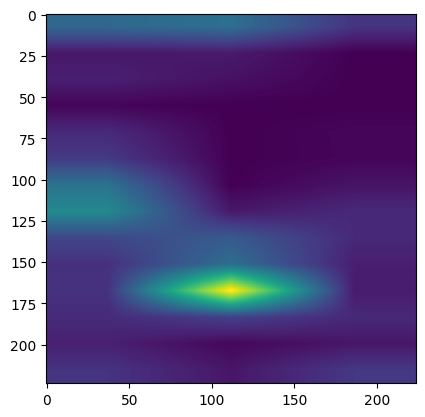

In [76]:
plt.imshow(cam)
#plt.imshow(img)

In [ ]:
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR))
plt.title('Input Image')
plt.show()

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
plt.title('Grad-CAM Output')
plt.show()